In [1]:
%matplotlib notebook
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from functools import reduce
import time

from aux import Generic, bin_occurrences
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *


In [10]:
def get_equally_spaced_colors(n, cmap='winter'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [3]:
get_equally_spaced_colors(10)

['#ff0000',
 '#ff1c00',
 '#ff3800',
 '#ff5500',
 '#ff7100',
 '#ff8e00',
 '#ffaa00',
 '#ffc700',
 '#ffe300',
 '#ffff00']

In [4]:
def graph_weight_matrix(mat, title, v_max=None, ax=None, cmap='hot'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
    else:
        ax.clear()
    ax.matshow(mat, vmin=0, vmax=v_max if v_max is not None else mat.max(), cmap=cmap) # 'gist_stern'
    ax.set_title(title)
#     ax.set_xlim(0, 100)
#     ax.set_ylim(100, 0)
    set_font_size(ax, 14)

In [5]:
def load_exp_data(direc, cut=None, layer_size=30, row_min=0, row_max=None, col_min=0, col_max=None):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    if cut is not None:
        file_names = file_names[:cut]
        
    df = pd.DataFrame({})
    
    for i_f in range(0, len(file_names)):
        file = file_names[i_f]
        loaded = sio.loadmat(os.path.join(direc, file))
        
        first_spk_times = loaded['first_spk_times'][0]
        w_r_e = loaded['w_r_e']
        
        if row_max is None:
            row_max = w_r_e.shape[0]
        if col_max is None:
            col_max = w_r_e.shape[1]
        target_w_r_e = w_r_e[row_min:row_max, col_min:col_max]
        
        summed_incoming_weights = target_w_r_e.sum(axis=1)
        
        
        df = df.append({
            'index': i_f,
            'first_spk_times': first_spk_times,
            'mean_incoming_summed_weights': np.mean(summed_incoming_weights),
            'std_incoming_summed_weights': np.std(summed_incoming_weights),
            'summed_incoming_weights': summed_incoming_weights,
            'max_synapse_size': target_w_r_e.max(),
        }, ignore_index=True)
    
    return df

In [29]:
def make_graphs(data_name):
    all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [data_name])

    num_layers = 19
    count = 0
    all_std_incoming_summed_weights_perturbed = []
    ratios_of_mean_incoming_summed_weights = []

    for exp_dir_name in sorted(all_dirs):

        exp_data = load_exp_data(os.path.join('./robustness', exp_dir_name), row_max=600, col_max=600, cut=500)

        print(exp_dir_name)

        count += 1

        fig, ax = plt.subplots(5, 1, figsize=(7, 18), tight_layout=True)

        std_incoming_summed_weights_perturbed = exp_data['std_incoming_summed_weights'].iloc[1]

        try:
            initial_mean_incoming_summed_weights = np.mean(exp_data['mean_incoming_summed_weights'].iloc[0])
            recovered_mean_incoming_summed_weights = np.mean(exp_data['mean_incoming_summed_weights'].iloc[len(exp_data) - 1])

            ratios_of_mean_incoming_summed_weights.append(recovered_mean_incoming_summed_weights / initial_mean_incoming_summed_weights)

            all_std_incoming_summed_weights_perturbed.append(std_incoming_summed_weights_perturbed)
        except IndexError as e:
            pass

        for i_trial in range(len(exp_data)):
            ax[2].scatter([i_trial], [np.sum(np.where(~np.isnan(exp_data['first_spk_times'].iloc[i_trial]), 1, 0))], c='black', s=6)
            ax[3].scatter([i_trial], [exp_data['mean_incoming_summed_weights'].iloc[i_trial]], c='red', s=6)

        ax[2].set_xlabel('Trial number')
        ax[2].set_ylabel(r'Number with neurons with >=1 spike')

        ax[3].set_xlabel('Trial number')
        ax[3].set_ylabel('Average incoming summed\n synapse strength per neuron')

        print(exp_data['max_synapse_size'].iloc[0])
        print(exp_data['max_synapse_size'].iloc[len(exp_data) - 1])


        fig2, ax2 = plt.subplots(2, 1, figsize=(7, 6), tight_layout=True)
        steps = 6
        max_y = 0
        max_x = 0

        summed_incoming_weights_thresh = None

        colors = get_equally_spaced_colors(steps)
        max_count = 0
        for j in range(steps):
            trial_num = int((len(exp_data) - 1) / steps * j)
            summed_incoming_weights = exp_data['summed_incoming_weights'].iloc[trial_num]
            x = trial_num * np.ones(len(summed_incoming_weights)) + np.random.normal(scale=0.4 * steps, size=len(summed_incoming_weights))
            ax2[0].scatter(x, summed_incoming_weights, s=1, c='black')

            if j == 0:
                summed_incoming_weights_thresh = np.mean(summed_incoming_weights) * 1.25

            counts_summed_weights_under_thresh = np.sum(np.where(summed_incoming_weights < summed_incoming_weights_thresh, 1, 0))
            if counts_summed_weights_under_thresh.max() > max_count:
                max_count = counts_summed_weights_under_thresh.max()
            ax2[1].scatter(trial_num, np.sum(np.where(summed_incoming_weights < summed_incoming_weights_thresh, 1, 0)), c='black', s=6)
            if j == 0:
                c = 'red'
            else:
                c = colors[j]
            ax[0].scatter(np.arange(len(summed_incoming_weights)), summed_incoming_weights, c=c, s=2)
            
        ax2[0].set_xlabel('Trial number')
        ax2[0].set_ylabel('Summed incoming weights')
        ax2[1].set_xlabel('Trial number')
        ax2[1].set_ylabel('Counts of summed incoming weights\n <1.25 * initial_mean')
        ax2[1].set_ylim(0, max_count * 1.05)


    fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
    ax.scatter(all_std_incoming_summed_weights_perturbed, ratios_of_mean_incoming_summed_weights, s=6, c='black')

    print(count)

$ \dot{w}_{ij} = \alpha (f_{j0} - f_j) $ for $f_j < f_{j0}$

noise_ff_0.0_pf_0.3_pr_0.0_eir_3.0_ier_1.0_dropout_sweep_2021-04-07--14:33--28:3513


<IPython.core.display.Javascript object>


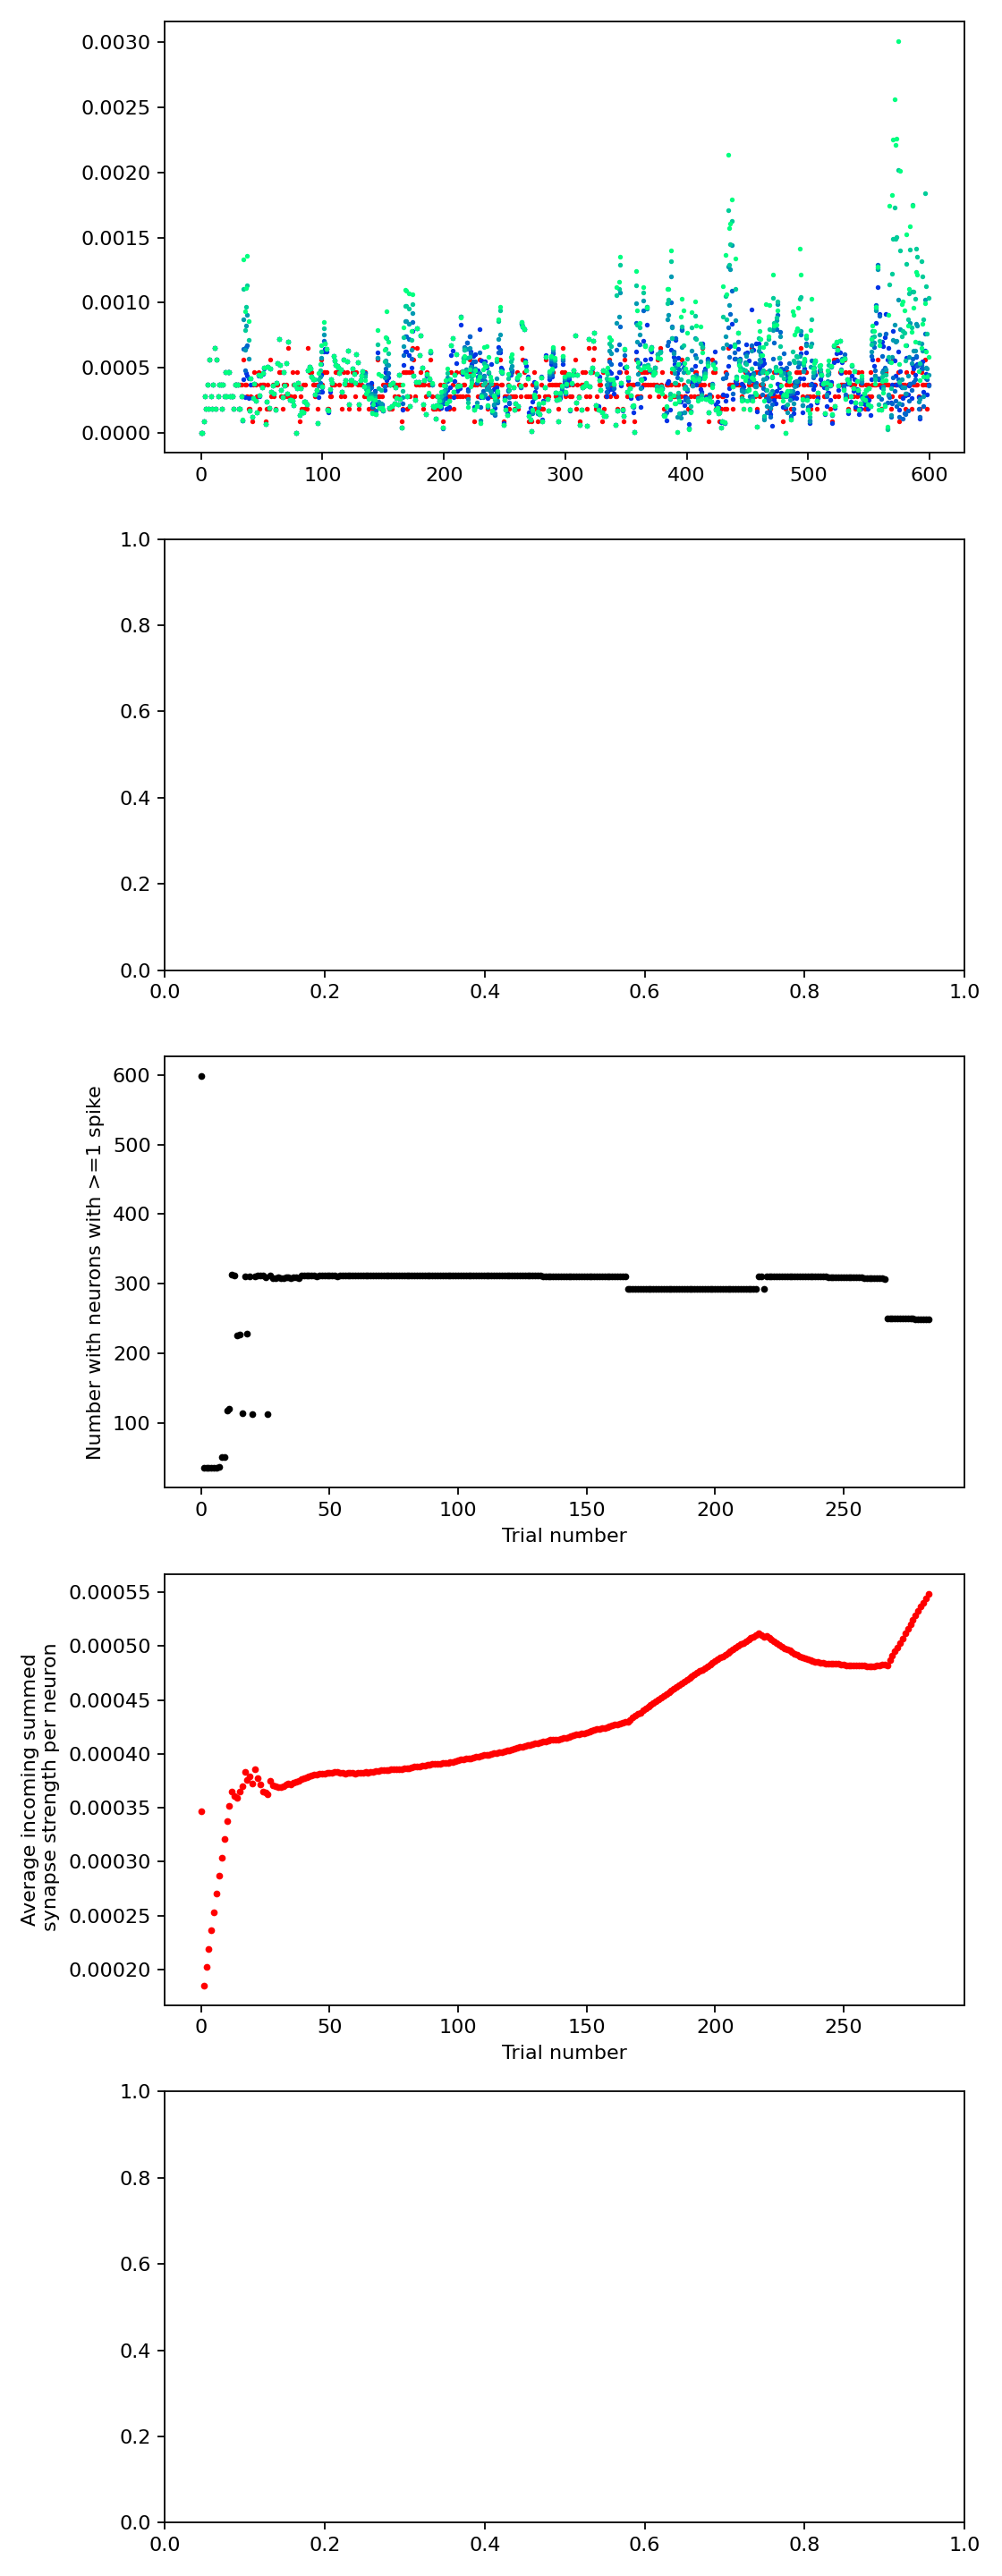

9.360000000000001e-05
0.0009360000000000001


<IPython.core.display.Javascript object>


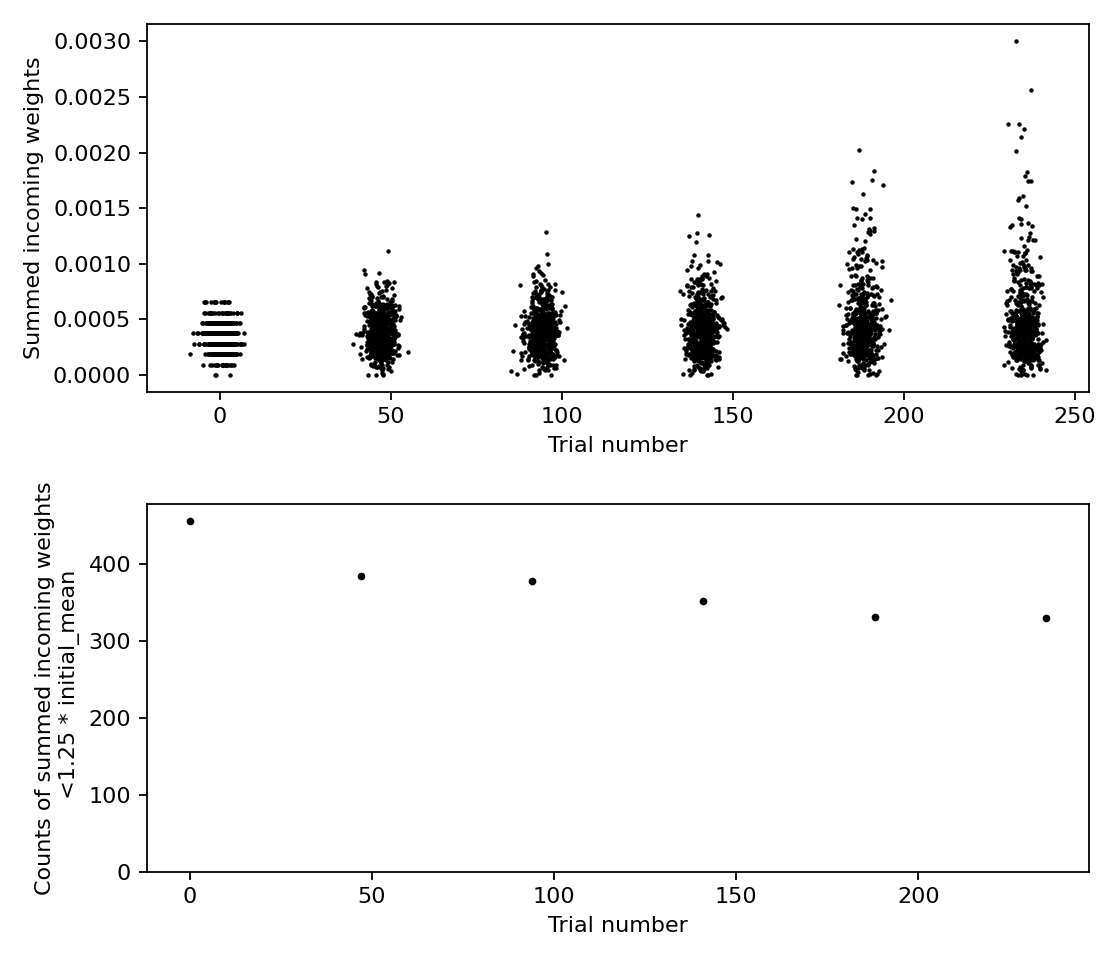

<IPython.core.display.Javascript object>


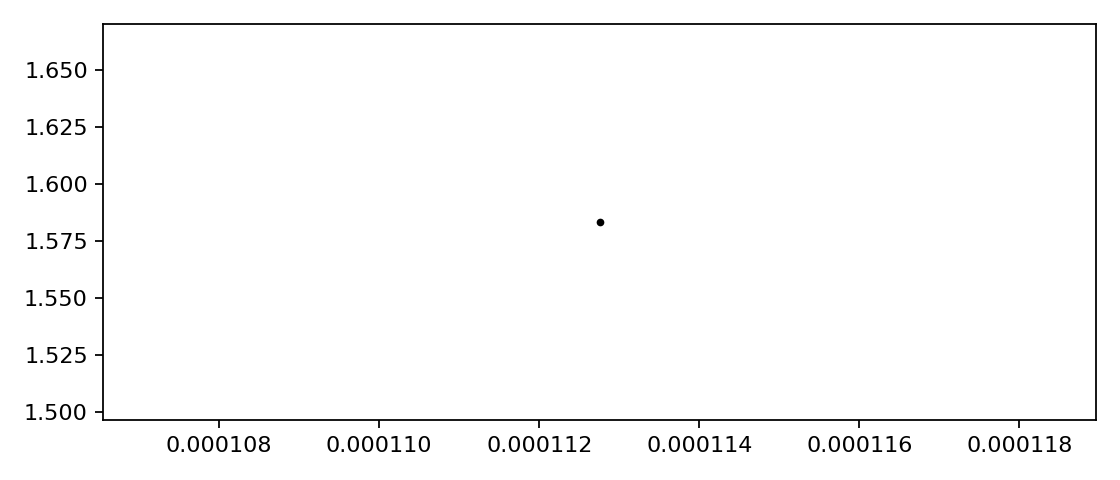

1


In [31]:
make_graphs('noise_ff_0.0_pf_0.3_pr_0.0_eir_3.0_ier_1.0_dropout_sweep_2021-04-07--14:33--28:3513')
